# EDA of "ChatGPT Classification Dataset"
#### Kaggle description
We have compiled a dataset that consists of textual articles including common terminology, concepts and definitions in the field of computer science, artificial intelligence, and cyber security. This dataset consists of both human-generated text and OpenAI’s ChatGPT-generated text. Human-generated answers were collected from different computer science dictionaries and encyclopedias including “The Encyclopedia of Computer Science and Technology” and "Encyclopedia of Human-Computer Interaction". AI-generated content in our dataset was produced by simply posting questions to OpenAI’s ChatGPT and manually documenting the resulting responses. A rigorous data-cleaning process has been performed to remove unwanted Unicode characters, styling and formatting tags. To structure our dataset for binary classification, we combined both AI-generated and Human-generated answers into a single column and assigned appropriate labels to each data point (Human-generated = 0 and AI-generated = 1).

This creates our article-level dataset (article_level_data.csv) which consists of a total of 1018 articles, 509 AI-generated and 509 Human-generated. Additionally, we have divided each article into its sentences and labelled them accordingly. This is mainly to evaluate the performance of classification models and pipelines when it comes to shorter sentence-level data points. This constructs our sentence-level dataset (sentence_level_data.csv) which consists of a total of 7344 entries (4008 AI-generated and 3336 Human-generated). 

In [2]:
import pandas as pd
import re
import unicodedata
import seaborn as sns
import spacy
import matplotlib.pyplot as plt
from nltk.probability import FreqDist # This is for counting the most frequent words
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize # this is for counting the senteces
plt.style.use('ggplot')

from collections import Counter
from functools import reduce
import language_tool_python
import lmppl

import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv("article_level_data.csv" , index_col= False )
data = data.drop(columns=["Unnamed: 0"])
data.head(5)

,article,class
0,NLP is a multidisciplinary field that draws fr...,0
1,There are a variety of emerging applications f...,0
2,As each new means of communication and social ...,0
3,"These suggestions include:, Learn about the pu...",0
4,In recent years there has been growing concern...,0


In [4]:
print(data.shape)
data.info()

(1018, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1018 entries, 0 to 1017
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   article  1018 non-null   object
 1   class    1018 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 16.0+ KB


In [5]:
# Checking missing values...
data.isna().sum()

article    0
class      0
dtype: int64

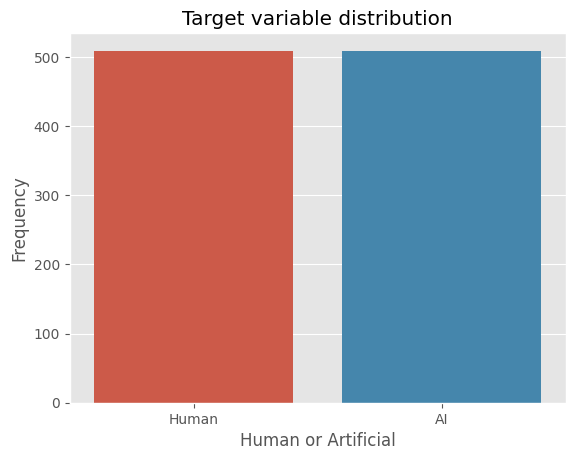

In [6]:
# Let's see the target class distribution
fig = sns.countplot(data, x = 'class')
fig.set(title = 'Target variable distribution', xlabel = 'Human or Artificial', ylabel = 'Frequency', xticklabels=['Human','AI'] )
plt.show()
# We have a very balanced dataset

# EDA --> Counts and lengths

#### Character Count

In [7]:
def article_length(text):
    return len(text)

data['length'] = data['article'].apply(article_length) 

In [8]:
print(data[data['class']==0].length.mean())
print(data[data['class']==1].length.mean())
# Not a big difference in the article's length

905.5795677799607
1124.7976424361493


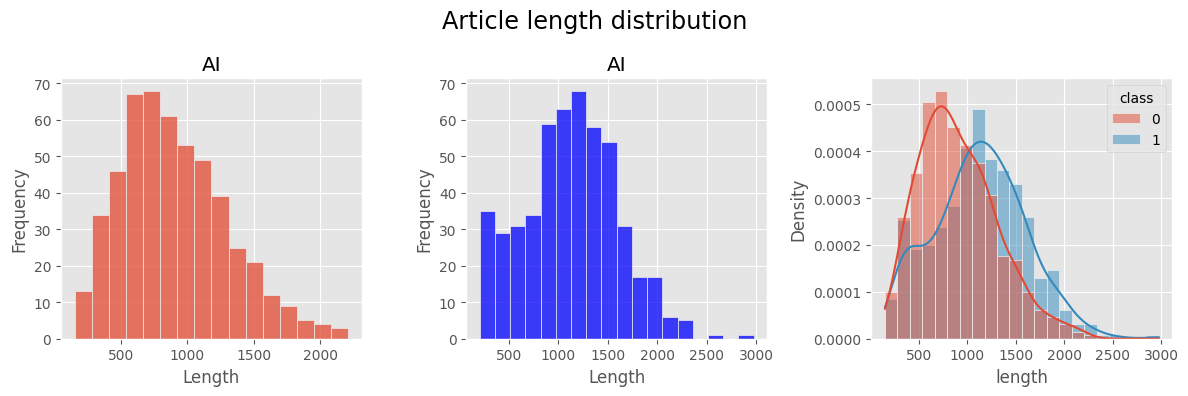

In [9]:
fig, axes = plt.subplots(1,3, figsize = (12,4))
fig_dist_human = sns.histplot(data = data[data['class']==0], x = 'length', ax = axes[0])
fig_dist_human.set(title = 'AI', xlabel='Length', ylabel= 'Frequency')
fig_dist_ai = sns.histplot(data = data[data['class']==1], x = 'length', ax = axes[1], color = 'blue')
fig_dist_ai.set(title = 'AI', xlabel='Length', ylabel= 'Frequency')
fig.suptitle('Article length distribution', fontsize =  'xx-large')
sns.histplot(data = data, x = 'length', hue="class", kde= True, stat = 'density', ax = axes[2] ) # Overlapped
plt.tight_layout()
# We can see that the AI articles are a bit longer but not so much

#### Words count

In [10]:
data['words'] = data['article'].apply(lambda x: len(str(x).split()))

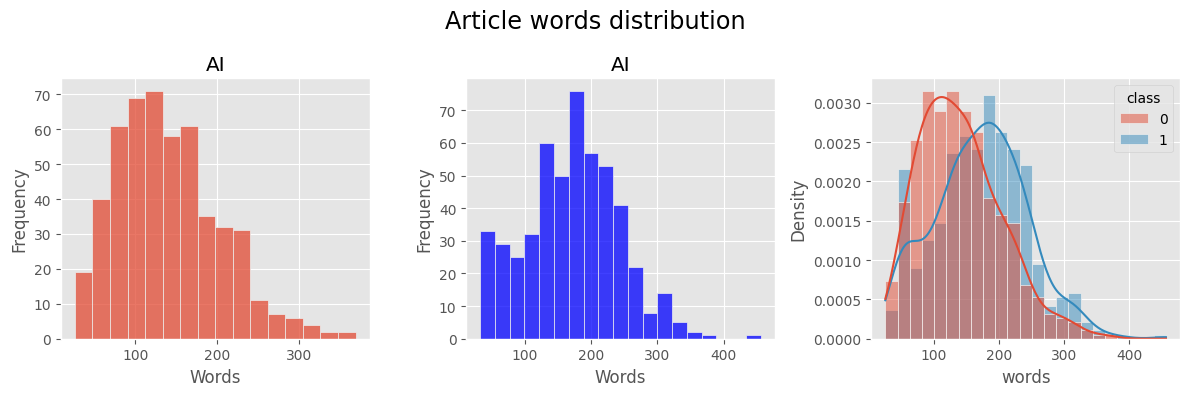

In [11]:
figg, axes = plt.subplots(1,3, figsize = (12,4))
fig_dist_human = sns.histplot(data = data[data['class']==0], x = 'words', ax = axes[0])
fig_dist_human.set(title = 'AI', xlabel='Words', ylabel= 'Frequency')
fig_dist_ai = sns.histplot(data = data[data['class']==1], x = 'words', ax = axes[1], color='blue')
fig_dist_ai.set(title = 'AI', xlabel='Words', ylabel= 'Frequency')
sns.histplot(data = data, x = 'words', hue='class', kde= True, stat = 'density', ax = axes[2]) 
figg.suptitle('Article words distribution', fontsize =  'xx-large')
plt.tight_layout()

# It is not the same as before, the x-axis is different! But of course they are similar because we are counting the words and the lenghts

#### Sentence Count

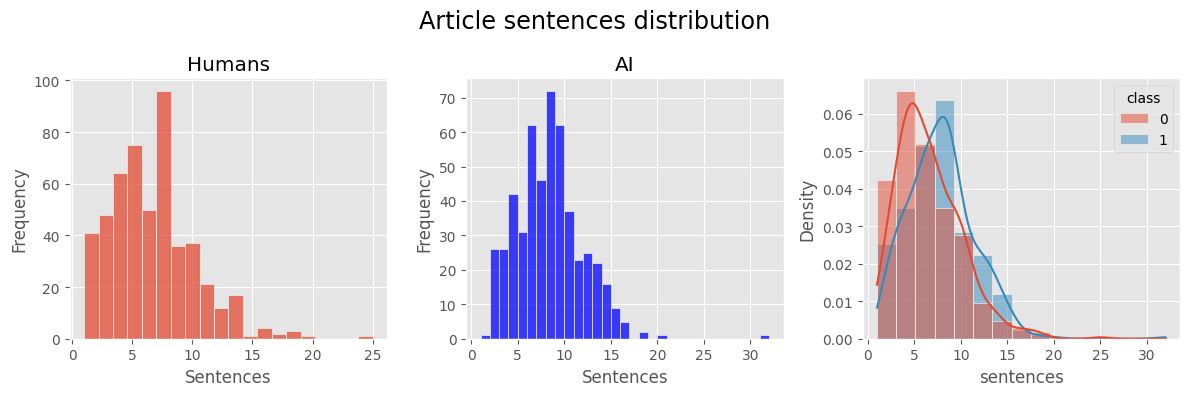

In [16]:
data['sentences'] = data['article'].map(lambda x: len(sent_tokenize(x)))
fig, axes = plt.subplots(1,3, figsize = (12,4))
fig_sentences_human = sns.histplot(data = data[data['class']==0], x = 'sentences', ax = axes[0])
fig_sentences_human.set(title = 'Humans', xlabel='Sentences', ylabel= 'Frequency')
fig_sentences_ai = sns.histplot(data = data[data['class']==1], x = 'sentences', ax = axes[1], color='blue')
fig_sentences_ai.set(title = 'AI', xlabel='Sentences', ylabel= 'Frequency')
sns.histplot(data = data, x = 'sentences', hue='class', kde= True, stat = 'density', ax = axes[2], bins = 15) 
fig.suptitle('Article sentences distribution', fontsize =  'xx-large')
plt.tight_layout()

# EDA --> Term frequency analysis

Steps I will follow:
1) Convert to lowercase
2) remove urls and html tags if any
3) Remove strange acceted characters if any
4) Remove punctuation
5) Remove extra white spaces 
6) Delet stop words

In [17]:
def lowering(text):
    return text.lower()

data['article_clean'] = data.article.apply(lowering)   

In [18]:
len(data[data.article_clean.str.contains('http')]) # there are 23 links, we can remove or not them, to be decided

23

In [19]:
def remove_url(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)

data['article_clean'] = data.article_clean.apply(remove_url)

In [20]:
def remove_accents(text):
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

data['article_clean'] = data.article_clean.apply(remove_accents)

In [21]:
def remove_punctuation(text):
    return re.sub(r'[^a-zA-Z0-9]', ' ', text)

data['article_clean'] = data.article_clean.apply(remove_punctuation)

In [22]:
def remove_extra_spaces(text):
    return re.sub(r'^\s*|\s\s*', ' ', text).strip()

data['article_clean'] = data.article_clean.apply(remove_extra_spaces)
data['article_nopunct'] = data.article_clean.copy()

In [23]:
# Spacy: 326 words to eliminate
en = spacy.load('en_core_web_sm')
sw_spacy = en.Defaults.stop_words

In [24]:
# Delete stop words
def delete_stopwords(text):
    words = [word for word in text.split() if word.lower() not in sw_spacy]
    new_text = " ".join(words)
    return new_text

# Create new columns with new text and new length
data['article_clean'] = data.article_clean.apply(delete_stopwords)

In [25]:
def most_common_words(data):
    corpus = [word for i in data['article_clean'].str.split().values.tolist() for word in i]
    most_common = FreqDist(corpus).most_common(40)
    words, frequency = [], []
    for word, count in most_common:
        words.append(word)
        frequency.append(count)   
    return dict(zip(words, frequency))

In [26]:
most_1_human = most_common_words(data[data['class']==0])
most_1_ai = most_common_words(data[data['class']==1])

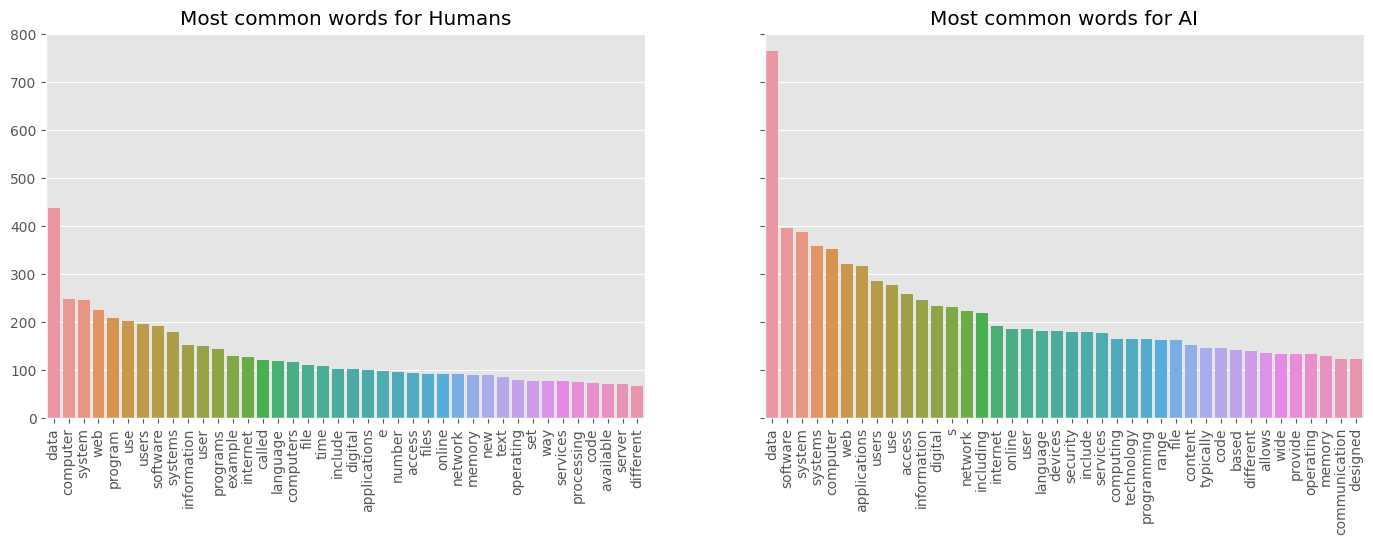

In [27]:
fig, axes = plt.subplots(1,2, figsize = (17,5), sharey= True)
sns.barplot(x = list(most_1_human.keys()), y = list(most_1_human.values()), ax = axes[0]).set(title="Most common words for Humans")
sns.barplot(x = list(most_1_ai.keys()), y = list(most_1_ai.values()), ax = axes[1]).set(title="Most common words for AI")
axes[0].tick_params(axis='x', rotation = 90)
axes[1].tick_params(axis='x', rotation = 90)
plt.show()

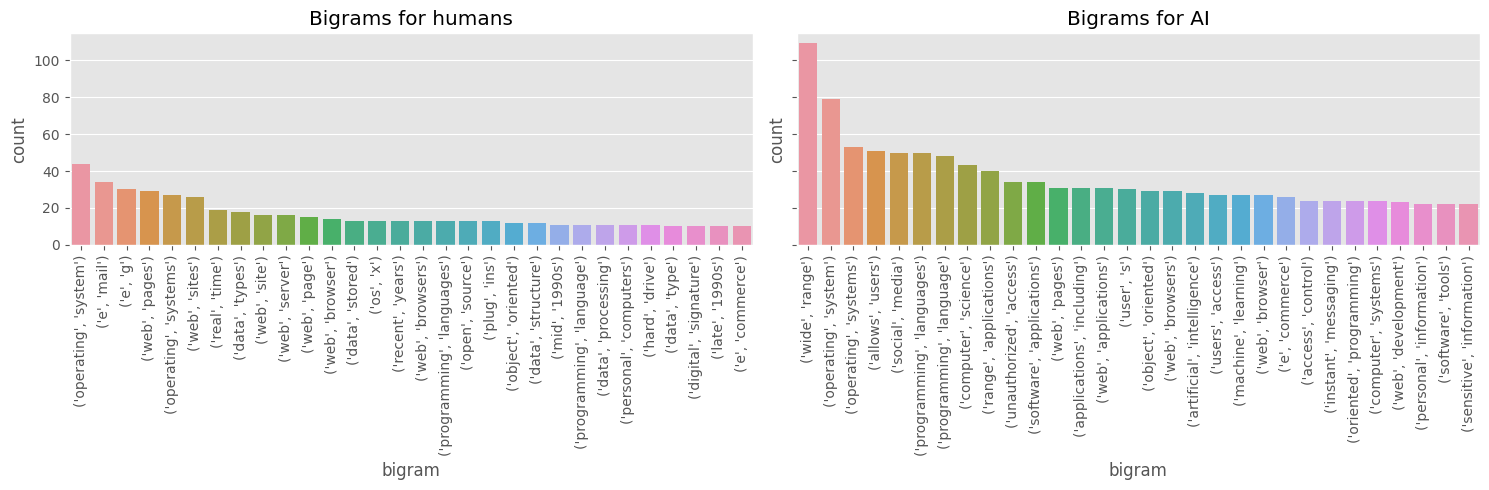

In [28]:
humans = data[data['class']==0]
corpus_humans = [word for i in humans.article_clean.str.split().values.tolist() for word in i]
bigrams_humans = (pd.Series(nltk.ngrams(corpus_humans, 2)).value_counts())
bigrams_df_h = bigrams_humans.reset_index()
bigrams_df_h.columns = ['bigram', 'count']

AI = data[data['class']==1]
corpus_AI = [word for i in AI.article_clean.str.split().values.tolist() for word in i]
bigrams_AI = (pd.Series(nltk.ngrams(corpus_AI, 2)).value_counts())
bigrams_df_AI = bigrams_AI.reset_index()
bigrams_df_AI.columns = ['bigram', 'count']

fig, axes = plt.subplots(1,2, figsize = (15,5), sharey=True)
sns.barplot(bigrams_df_h.head(30), x = 'bigram', y ='count', ax=axes[0]).set(title = 'Bigrams for humans')
sns.barplot(bigrams_df_AI.head(30), x = 'bigram', y ='count', ax=axes[1]).set(title = 'Bigrams for AI')
axes[0].tick_params(axis='x', rotation = 90)
axes[1].tick_params(axis='x', rotation = 90)
plt.tight_layout()

# Look! AI has very high frequences while humans at max 40 but I still need to fix tha data :)

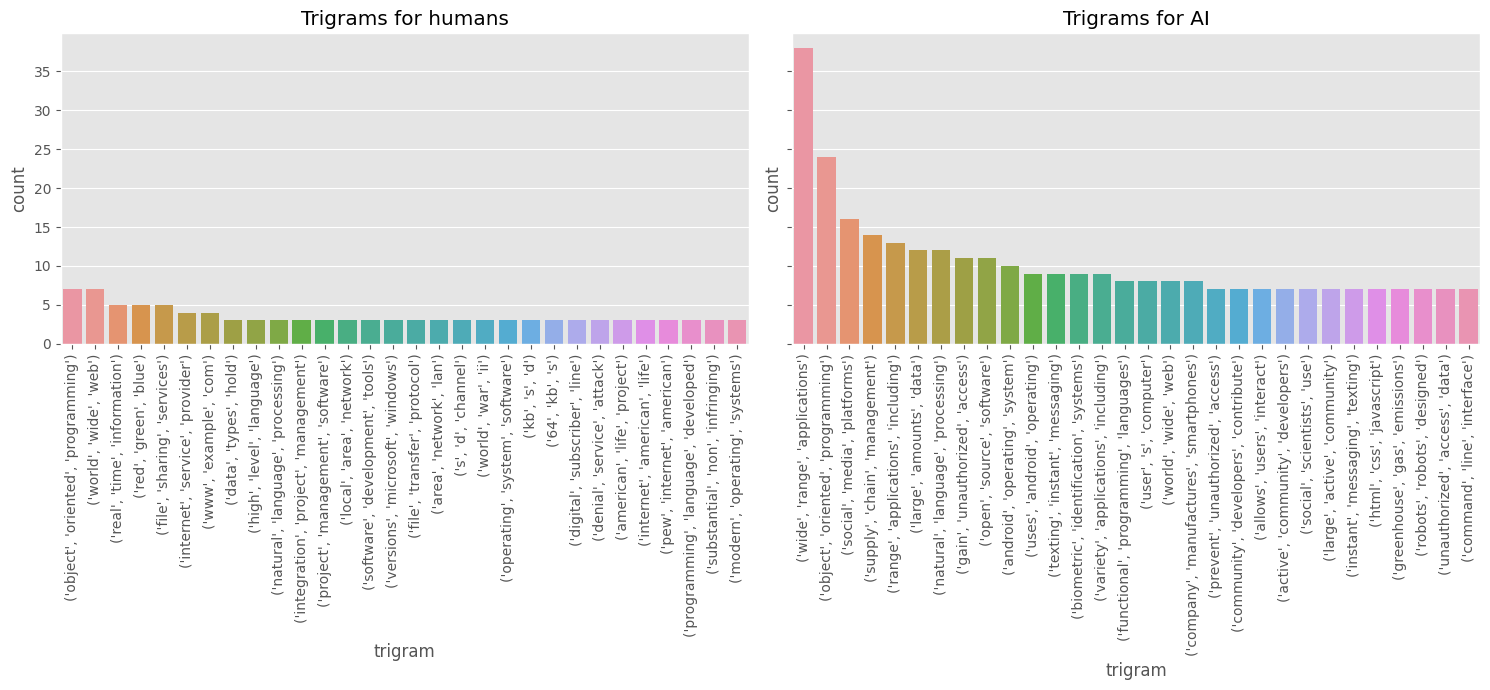

In [29]:
trigrams_humans = (pd.Series(nltk.ngrams(corpus_humans, 3)).value_counts())
trigrams_df_h = trigrams_humans.reset_index()
trigrams_df_h.columns = ['trigram', 'count']

trigrams_AI = (pd.Series(nltk.ngrams(corpus_AI, 3)).value_counts())
trigrams_df_AI = trigrams_AI.reset_index()
trigrams_df_AI.columns = ['trigram', 'count']

fig, axes = plt.subplots(1,2, figsize = (15,7), sharey= True) 
sns.barplot(trigrams_df_h.head(30), x = 'trigram', y ='count', ax=axes[0]).set(title = 'Trigrams for humans')
sns.barplot(trigrams_df_AI.head(30), x = 'trigram', y ='count', ax=axes[1]).set(title = 'Trigrams for AI')
axes[0].tick_params(axis='x', rotation = 90)
axes[1].tick_params(axis='x', rotation = 90)
plt.tight_layout()

Let's build the feature for the 2-grams:

In [36]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from collections import Counter

In [37]:
corpus = [word for i in data.article_clean.str.split().values.tolist() for word in i]
bigram = (pd.Series(nltk.ngrams(corpus, 2)).value_counts())
unique_bigrams = bigram.head(50).index.tolist()

In [38]:
data['total_bigram_count'] = 0

In [39]:
def sum_bigram_counts(row):
    words = row['article_clean'].split()
    row_bigrams = list(nltk.ngrams(words, 2))
    
    # if the bigram is one of the 50 most frequent and if it is in the row sum 1
    row_count = sum(1 for bigram in row_bigrams if bigram in unique_bigrams)
    
    row['total_bigram_count'] = row_count

    return row

In [40]:
data = data.apply(sum_bigram_counts, axis=1)
data.head()

,article,class,length,words,sentences,article_clean,article_nopunct,total_bigram_count
0,NLP is a multidisciplinary field that draws fr...,0,1112,187,6,nlp multidisciplinary field draws linguistics ...,nlp is a multidisciplinary field that draws fr...,3
1,There are a variety of emerging applications f...,0,630,82,2,variety emerging applications nlp including fo...,there are a variety of emerging applications f...,0
2,As each new means of communication and social ...,0,1135,176,8,new means communication social interaction int...,as each new means of communication and social ...,0
3,"These suggestions include:, Learn about the pu...",0,1018,173,10,suggestions include learn purpose newsgroup po...,these suggestions include learn about the purp...,1
4,In recent years there has been growing concern...,0,699,111,3,recent years growing concern internet users ev...,in recent years there has been growing concern...,1


### Logistic Regression with Gradient Ascent

We employ the logistic regression model as the initial approach for our classification task.

Logistic Regression uses as hypothesis the sigmoid function, which represents the probability that an instance belongs to a specific class, in this case the probability that the article is written by ChatGPT<br>

hypothesis $h_\theta(x)= P(y=1|x;\theta)$ $=\frac{1}{1+\exp(-\theta^T x)}$

The training process involves finding the set of parameters θ that maximizes the likelihood of the observed data. 

\begin{align}
L(\theta) &= \prod_{i=1}^{m} h_\theta(x^{(i)})^{y^{(i)}} \left( 1 - h_\theta(x^{(i)}) \right)^{1 - y^{(i)}} \\
L(\theta) &= \prod_{i=1}^{m} \left( \frac{1}{1 + e^{-\theta^T x^{(i)}}} \right)^{y^{(i)}} \left(1 - \frac{1}{1 + e^{-\theta^T x^{(i)}}}\right)^{1 - y^{(i)}}
\end{align}

where y is the class label of th i-th example (0 or 1), x is the i-th input data, θ are the model parameters, and m is the number of examples in the training set.


In logistic regression, this is typically done by maximizing the log-likelihood. The likelihood function represents the probability of observing the given set of outcomes (classes) for the input data. The log-likelihood is used for mathematical convenience, and the optimization problem becomes finding the parameters that maximize the log-likelihood.

\begin{align}
l(\theta) &= \log L(\theta) \\
l(\theta) &= \sum_{i=1}^{m} \left[ (y^{(i)} - 1) \theta^T x^{(i)} - \log (1 + e^{\theta^T x^{(i)}}) \right] 
\end{align}

The gradient of the log likelihood with respect to the parameters θ is calculated as follows:

\begin{align}
\frac{\partial l(\theta)}{\partial \theta} &= \sum_{i=1}^{m} \left[ (y^{(i)} - h_\theta(x^{(i)})) x^{(i)} \right] \\
\frac{\partial l(\theta)}{\partial \theta} &= \sum_{i=1}^{m} \left[ (y^{(i)} - 1) x^{(i)} - \frac{e^{\theta^T x^{(i)}}}{1 + e^{\theta^T x^{(i)}}} \cdot x^{(i)} \right] \\
\end{align}

To maximize the log likelihood, optimization methods like gradient ascent are used. 

For \( j=0,...,n \), where n is the number of features:
\begin{equation}
\theta_j := \theta_j + \alpha \left[ \sum_{i=1}^{m} \left( y^{(i)} - h_\theta(x^{(i)}) \right) x_j^{(i)} \right]
\end{equation}

where α is the learning rate, i is the index of the example and j is the index of the element of the i-th example.

The process continues until convergence is reached or a stopping criterion is satisfied.

#### Definition of the functions needed for the Logistic Regression Model

In [33]:
# Function to compute the sigmoid of a given input x.
def sigmoid(x):
    g = 1 / (1 + np.exp(-x))
    return g


# Function to compute the log likehood of theta according to data x and label y.
def log_likelihood(theta, x, y):
    
    h = sigmoid(np.dot(x, theta))
    log_l = np.mean(y * np.log(h) + (1 - y) * np.log(1 - h))
    return log_l


# Function to compute the predictions for the input features.
def predictions(features, theta):
    
    preds = sigmoid(np.dot(features, theta))
    return preds


#  Function to compute the gradient of the log likelihood and then return the updated weights.
def update_theta(theta, target, preds, feat, lr):
    
    gradient = np.dot(feat.T, (target - preds)) / feat.shape[0]
    theta += lr * gradient
    return theta
    

# Function to execute the gradient ascent algorithm.
def gradient_ascent(theta, feat, target, lr, num_steps):
    
    log_likelihood_history = []
    
    for step in range(num_steps):
        preds = predictions(feat, theta)
        theta = update_theta(theta, target, preds, feat, lr)
        log_l = log_likelihood(theta, feat, target)
        log_likelihood_history.append(log_l)
        
    return theta, log_likelihood_history

### LOGISTIC REGRESSION with TF-IDF

Let's begin by applying a Logistic Regression model to a DataFrame, where the feature values are derived from the TF-IDF transformation of the "article" column. This transformation is performed after preprocessing the strings and stemming their words.

In [34]:
# import libraries for tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

In [35]:
data.head()

,article,class,length,words,sentences,article_clean,article_nopunct
0,NLP is a multidisciplinary field that draws fr...,0,1112,187,6,nlp multidisciplinary field draws linguistics ...,nlp is a multidisciplinary field that draws fr...
1,There are a variety of emerging applications f...,0,630,82,2,variety emerging applications nlp including fo...,there are a variety of emerging applications f...
2,As each new means of communication and social ...,0,1135,176,8,new means communication social interaction int...,as each new means of communication and social ...
3,"These suggestions include:, Learn about the pu...",0,1018,173,10,suggestions include learn purpose newsgroup po...,these suggestions include learn about the purp...
4,In recent years there has been growing concern...,0,699,111,3,recent years growing concern internet users ev...,in recent years there has been growing concern...


In [41]:
# create a new DataFrame called df, dropping the columns that we don't want to use from the original dataset
df = data.drop(columns=["article", "length", "words", "sentences", "total_bigram_count"])

# reorders the columns
df = df[['article_clean', 'class']]

df.head()

,article_clean,class
0,nlp multidisciplinary field draws linguistics ...,0
1,variety emerging applications nlp including fo...,0
2,new means communication social interaction int...,0
3,suggestions include learn purpose newsgroup po...,0
4,recent years growing concern internet users ev...,0


In the updated DataFrame, denoted as "df," there are only two columns: "article_clean," storing the preprocessed articles presented as strings, and "class" representing the corresponding label (0 for human, 1 for ChatGPT).

Moving forward, our next step involves applying stemming to the words within the "article_clean" column. Subsequently, we concatenate these stemmed words to reconstruct the sentences into cohesive strings.

In [42]:
def stemming(text):
    # Tokenization
    words = word_tokenize(text)
    
    # Stemming
    stemmer = PorterStemmer()
    stemmed_words = [stemmer.stem(word) for word in words]
    
    # Reconstruct the text after stemming
    processed_text = ' '.join(stemmed_words)
    
    return processed_text

In [43]:
# Apply the stemming function to the 'abstract_clean' column
df['article_clean'] = df['article_clean'].apply(stemming)
df.head()

,article_clean,class
0,nlp multidisciplinari field draw linguist comp...,0
1,varieti emerg applic nlp includ follow voic co...,0
2,new mean commun social interact introduc socia...,0
3,suggest includ learn purpos newsgroup post gro...,0
4,recent year grow concern internet user eventu ...,0


Performing a TF-IDF (Term Frequency-Inverse Document Frequency) transformation using the scikit-learn library.
Our primary objective is to analyze the textual content of the "artcile_clean" column of the DataFrame named "df".

Next, we propose to augment the DataFrame by incorporating the TF-IDF matrix derived from this analysis. This augmented DataFrame will serve as the basis for training our logistic regression model.

In [44]:
# Create a TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')  

# Apply TF-IDF to the 'sentence_clean' column
tfidf_matrix = tfidf_vectorizer.fit_transform(df['article_clean'])

# Convert the sparse matrix to a dense representation
dense_tfidf_matrix = tfidf_matrix.todense()

# Add the resulting dense matrix as columns to the DataFrame
df = pd.concat([df, pd.DataFrame(dense_tfidf_matrix, columns=tfidf_vectorizer.get_feature_names_out())], axis=1)

In [45]:
# Now we drop the 'abstract_clean' column because we don't need it anymore
df = df.drop(columns=["article_clean"])
df.head(10)

,class,00,000,05,06,0stripe,10,100,101,1012,...,zdnet,zero,zimmermann,zip,zone,zoom,zsoft,zuckerberg,zuse,zuseus
0,0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0,0.0,0.1076,0.0,0.0,0.0,0.092603,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0,0.0,0.0000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# sets up pandas table display
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)



Steps 1: DATA SPLITTING

The dataset is divided into features (X) and the target variable (y). Features are stored in X, and the target variable ('class') is stored in y.
The data is then split into training, test, and validation sets using the train_test_split function from scikit-learn. 
The training set contains 60% of the data, the test set contains 20%, and the validation set contains the remaining 20%.
The random_state is set to 42 for reproducibility.

In [47]:
df = df.loc[:, ~df.columns.duplicated()] # remove duplicates columns

# 'class' is the target variable and the rest of the columns are used as features
X = df.drop('class', axis=1)
y = df['class']

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, shuffle=True, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=True, random_state=42)

STEP 2: BIAS TERM ADDICTION:

A column of ones is added to the standardized features for the bias term. This is done to account for the intercept in the logistic regression model.


In [48]:
# Add a column of ones to the features for the bias term
X_train = np.c_[np.ones(X_train.shape[0]), X_train]
X_test = np.c_[np.ones(X_test.shape[0]), X_test]
X_val = np.c_[np.ones(X_val.shape[0]), X_val]

#### Hyperparameters Tuning

To tune hyperparameters, we use a technique called grid search for learning rate and the number of steps. This involve training the model with different combinations of hyperparameters and selecting the combination that performs the best on a validation set

In [51]:
flag = False

if flag:
    # Define a grid of hyperparameter values to search
    learning_rates = [0.0001, 0.001, 0.01, 0.1]
    num_steps_values = [1000, 1500, 2000, 2500, 3000]

    best_params = None
    best_accuracy = 0

    # Perform grid search
    for lr in learning_rates:
        for num_steps in num_steps_values:
            # Initialize parameters
            theta = np.random.normal(0, 0.01, X_train.shape[1])

            # Perform gradient ascent
            theta_final, log_likelihood_history = gradient_ascent(theta, X_train, y_train, lr, num_steps)

            # Make predictions on the validation set
            val_preds = predictions(X_val, theta_final)

            # Calculate accuracy on the validation set
            accuracy = np.mean(val_preds.round() == y_val)

            # Update best parameters if the current combination is better
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {'learning_rate': lr, 'num_steps': num_steps}

    # Print the best hyperparameters
    print("Best Hyperparameters:", best_params)
    

The parameters (weights) of the logistic regression model are initialized using random values. Specifically, we are using a normal distribution with a mean of 0 and a standard deviation of 0.01 to initialize the parameters. These parameters are stored in the variable theta;

Then, the hyperparameters are set to control the learning process of the logistic regression model:
learning_rate determines the step size during the gradient ascent optimization process and num_steps represents the number of iterations or steps taken during the gradient ascent optimization. 

After the hyperparameters tuning, we have found out that the best combination of learning rate and number of iterations is lr=0.1 and num_steps=2500, so we show the results with this pair of parameters.

In [52]:
# Initialize theta 
theta = np.random.normal(0, 0.01, X_train.shape[1])

# Set hyperparameters
learning_rate = 0.1
num_steps = 2500


The logistic regression model is trained on the training set using the gradient ascent optimization algorithm. The gradient_ascent function is called with the initialized parameters, training features, target values, learning rate, and the number of steps.

The function returns the optimized parameters (theta_final) and a history of log-likelihood values during optimization (log_likelihood_history).

In [53]:
# Perform logistic regression on the training set
theta_final, log_likelihood_history = gradient_ascent(theta, X_train, y_train, learning_rate, num_steps)

#### Predictions on Training, Test, and Validation Sets:

Predictions are made using the trained model on the training set (X_train_scaled_bias), test set (X_test_scaled_bias), and validation set (X_val_scaled_bias).

In [54]:
# Make predictions on the training set
train_preds = predictions(X_train, theta_final)

# Make predictions on the test set
test_preds = predictions(X_test, theta_final)

# Evaluate the model on the validation set
validation_preds = predictions(X_val, theta_final)

Now we evaluate the performances of the logistic regression model, using different metrics:

1) Accuracy:<br>
number of correct classified examples over total number of examples

In [55]:
accuracy_train = np.mean(train_preds.round() == y_train)
print(f'Accuracy training-set: {accuracy_train:.2%}')

accuracy_test = np.mean(test_preds.round() == y_test)
print(f'Accuracy test-set: {accuracy_test:.2%}')

accuracy_val = np.mean(validation_preds.round() == y_val)
print(f'Accuracy validation-set: {accuracy_val:.2%}')

Accuracy training-set: 93.77%
Accuracy test-set: 77.94%
Accuracy validation-set: 77.45%


2) Precision:<br>
(True Positives) / (True Positives + False Positives)

In [56]:
precision_train = np.sum((train_preds.round() == 1) & (y_train == 1)) / np.sum(train_preds.round() == 1)
print(f'Precision training-set: {precision_train:.2%}')

precision_test = np.sum((test_preds.round() == 1) & (y_test == 1)) / np.sum(test_preds.round() == 1)
print(f'Precision test-set: {precision_test:.2%}')

precision_val = np.sum((validation_preds.round() == 1) & (y_val == 1)) / np.sum(validation_preds.round() == 1)
print(f'Precision validation-set: {precision_val:.2%}')


Precision training-set: 93.83%
Precision test-set: 75.70%
Precision validation-set: 82.35%


3) Recall (Sensitivity):<br>
(True Positives) / (True Positives + False Negatives)

In [57]:
recall_train = np.sum((train_preds.round() == 1) & (y_train == 1)) / np.sum(y_train == 1)
print(f'Recall training-set: {recall_train:.2%}')

recall_test = np.sum((test_preds.round() == 1) & (y_test == 1)) / np.sum(y_test == 1)
print(f'Recall test-set: {recall_test:.2%}')

recall_val = np.sum((validation_preds.round() == 1) & (y_val == 1)) / np.sum(y_val == 1)
print(f'Recall validation-set: {recall_val:.2%}')

Recall training-set: 93.83%
Recall test-set: 81.00%
Recall validation-set: 69.31%


4) F1 Score:<br>
(precision * recall) / (precision + recall)

In [58]:
f1_score_train = 2 * (precision_train * recall_train) / (precision_train + recall_train)
print(f'F1 Score training-set: {f1_score_train:.2%}')

f1_score_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print(f'F1 Score test-set: {f1_score_test:.2%}')

f1_score_val = 2 * (precision_val * recall_val) / (precision_val + recall_val)
print(f'F1 Score validation-set: {f1_score_val:.2%}')

F1 Score training-set: 93.83%
F1 Score test-set: 78.26%
F1 Score validation-set: 75.27%


5) Confusion Matrix:

remind the Confusion Mtrix structure:<br>

- True Positive (TP): Instances that are actually positive and are correctly predicted as positive.
- True Negative (TN): Instances that are actually negative and are correctly predicted as negative.
- False Positive (FP): Instances that are actually negative but are incorrectly predicted as positive.
- False Negative (FN): Instances that are actually positive but are incorrectly predicted as negative.

The rows typically represent the actual classes, and the columns represent the predicted classes. The diagonal elements (top-left to bottom-right) are the instances that are correctly classified, while the off-diagonal elements represent the misclassifications.


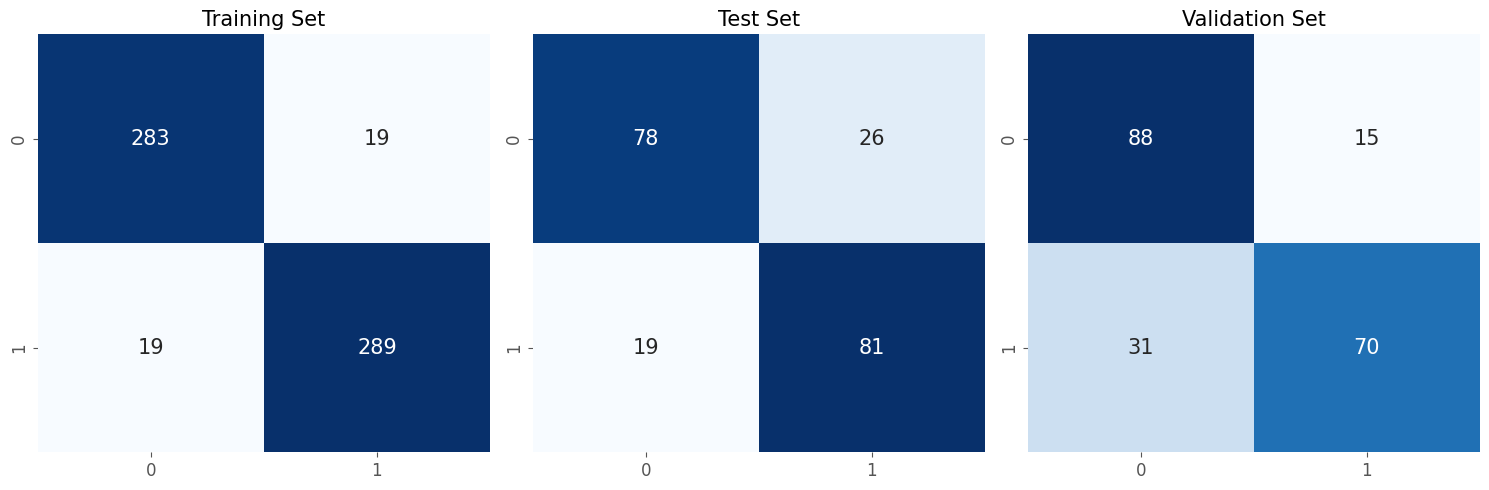

In [59]:
# compute confusion matrix for training / test / validation sets
confusion_train = confusion_matrix(y_train, train_preds.round())
confusion_test = confusion_matrix(y_test, test_preds.round())
confusion_val = confusion_matrix(y_val, validation_preds.round())


# Set up subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Plot training set confusion matrix
sns.heatmap(confusion_train, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 15}, ax=axes[0])
axes[0].set_title('Training Set', fontsize=15)  # Adjust title font size

# Plot test set confusion matrix
sns.heatmap(confusion_test, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 15}, ax=axes[1])
axes[1].set_title('Test Set', fontsize=15)  # Adjust title font size

# Plot validation set confusion matrix
sns.heatmap(confusion_val, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 15}, ax=axes[2])
axes[2].set_title('Validation Set', fontsize=15)  # Adjust title font size

# Adjust tick label font size
for ax in axes:
    ax.tick_params(axis='both', labelsize=12)

# Display the plots
plt.tight_layout()
plt.show()

As we can see from the various metrics used to measure the goodness of our model, it would seem that ultilizing the values of the tfidf matrix obtained by transforming the articles in the dataset, leads to very good performance. 

Considering for example the accuracy, we see that we get an accuracy of about 93 percent on the training set, so we are not overfitting, and very quite high accuracy values even on data not seen before, that is, on the testset and validation set examples, where we succeed in classifying about 76 percent of the example data.

Upon closer examination of the confusion matrices, we observe a balanced distribution of misclassified examples, regarding false positives and false negatives. Notably, there is no discernible inclination to categorize the majority of examples as either 1 or 0, a pattern consistently observed across the test and validation sets too.

In conclusion, the TF-IDF matrix emerges as a promising feature set for training the logistic regression model.

### NEW FEATURES

List of features to extract: 
1. Features that identify diversity and richness in the vocabulary (if we have to choose, keep Herdan's C, it's the best one for the task according to a paper)
    - Herdan's C
    - MaaS
    - Simpson's index

2. Perplexity 
3. Grammar Score 
4. N-grams distribution -> in the end no: it's shit to be summarized (the means are all low and don't make distinctions between Human and AI)
5. Type Token Ratio (TTR) on N-grams for N=1,2,3
6. Length (article - level: done in the eda, column 'words')
7. Average token length

Everything done on partially pre-procesed articles: only no punctuation but we keep the stopwords.

Before getting the features, we add some columns to the dataset that containg infromations needed to compute more then one feature. We will drop these columns afterwards. 

In [ ]:
# Loading the original dataset 
data = pd.read_csv("article_level_data.csv" , index_col= False )
data.drop(columns=["Unnamed: 0"])

# article_clean as a list, useful
data['article_list'] = data.article_nopunct.apply(str.split)


Computing the vocabulary

In [ ]:
vocabulary = Counter(reduce(lambda x,y : x+y, data.article_list.values))

# get the vocabulary length and its log (for Herdan's C and MaaS)
voc_len = len(vocabulary)
log_voc_len = np.log(voc_len)


In [ ]:
# Herdan's C
data['herdan'] = data.words.apply(lambda row: log_voc_len/np.log(row))

# MaaS
data['maas'] = data.words.apply(lambda row: (log_voc_len - np.log(row)) / np.log((voc_len**2)) )

# Simpson's index 
data['tf'] = data.article_list.apply(lambda row: Counter(row))
data['tf'] = data.tf.apply(lambda row: row.values())
simpson_help = zip(data.tf, list(data.words))
data['simpson'] = list(simpson_help)
data['simpson'] = data.simpson.apply(lambda row: [(val/row[1])**2 for val in row[0]]).apply(lambda row: 1-sum(row))

# Grammar score 
tool = language_tool_python.LanguageTool('en-US')
data['grammar_score'] = data.article.apply(lambda row: len(tool.check(row))) #number of errors per row
grammar_score_help = zip(data.grammar_score, data.words)
data['grammar_score'] = list(grammar_score_help)
data['grammar_score'] = data.grammar_score.apply(lambda row: (row[0]/row[1]) ) #compute grammar score

# TTR on the whole text = on 1-grams (saved as TTR1)
# for this section: type = len(tf), token = words
data['TTR1'] = list(zip(list(data.tf.apply(len)), data.words))  #assign (type, token) as value for each row
data['TTR1'] = data.TTR1.apply(lambda row: row[0]/row[1])       #compute TTR

# TTR on 2-grams, prevalence of 2grams
data['bigrams'] = data.article_clean.apply(str.split).apply(lambda row: nltk.ngrams(row, 2)) #create bigrams for each document
data['TTR2'] = data.bigrams.apply(Counter                                     #count the occurency of each bigram
                                  ).apply(lambda row: (len(row), sum(row.values()) ) #returns (type, token) couple for each row
                                  ).apply(lambda row: row[0]/row[1] )                #computes TTR


#TTR on 3-grams, prevalence of trigrams
data['trigrams'] = data.article_clean.apply(str.split).apply(lambda row: nltk.ngrams(row, 3)) #create bigrams for each document
data['TTR3'] = data.trigrams.apply(Counter                                    #count the occurencies of each trigram
                                  ).apply(lambda row: (len(row), sum(row.values()) ) #returns (type, token) couple for each row
                                  ).apply(lambda row: row[0]/row[1] )                #computes TTR


# Average token length 
data['avg_token_length'] = data.article_list.apply(lambda row: [len(word) for word in row]).apply(lambda row: sum(row)/len(row))

# Perplexity 
scorer = lmppl.LM('gpt2')
data['perplexity'] = data.article.apply(scorer.get_perplexity)

In [ ]:
data.drop(['bigrams', 'trigrams', 'tf', 'Unnamed: 0'], axis=1, inplace=True)

In [ ]:
data

,article,class,length,words,sentences,article_clean,total_bigram_count,article_nopunct,article_list,herdan,maas,simpson,grammar_score,TTR1,TTR2,TTR3,avg_token_length,perplexity
0,NLP is a multidisciplinary field that draws fr...,0,1112,187,6,nlp multidisciplinary field draws linguistics ...,3,nlp is a multidisciplinary field that draws fr...,"[nlp, is, a, multidisciplinary, field, that, d...",1.778976,0.218939,0.984157,0.021390,0.609626,0.988235,1.000000,4.804348,35.369075
1,There are a variety of emerging applications f...,0,630,82,2,variety emerging applications nlp including fo...,0,there are a variety of emerging applications f...,"[there, are, a, variety, of, emerging, applica...",2.111778,0.263233,0.978882,0.036585,0.768293,1.000000,1.000000,6.250000,58.814785
2,As each new means of communication and social ...,0,1135,176,8,new means communication social interaction int...,0,as each new means of communication and social ...,"[as, each, new, means, of, communication, and,...",1.799834,0.222197,0.985182,0.022727,0.693182,0.989691,1.000000,5.285714,53.423985
3,"These suggestions include:, Learn about the pu...",0,1018,173,10,suggestions include learn purpose newsgroup po...,1,these suggestions include learn about the purp...,"[these, suggestions, include, learn, about, th...",1.805839,0.223120,0.986100,0.034682,0.647399,0.987013,1.000000,4.779762,34.250844
4,In recent years there has been growing concern...,0,699,111,3,recent years growing concern internet users ev...,1,in recent years there has been growing concern...,"[in, recent, years, there, has, been, growing,...",1.975996,0.246963,0.982225,0.027027,0.702703,0.983607,1.000000,5.284404,25.693995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1013,Palettes can refer to different things dependi...,1,777,132,6,palettes refer different things depending cont...,1,palettes can refer to different things dependi...,"[palettes, can, refer, to, different, things, ...",1.905876,0.237653,0.973887,0.022727,0.553030,0.984848,1.000000,4.729323,13.300089
1014,Probability is a measure of the likelihood tha...,1,893,148,8,probability measure likelihood specific event ...,2,probability is a measure of the likelihood tha...,"[probability, is, a, measure, of, the, likelih...",1.862241,0.231506,0.977401,0.000000,0.554054,0.973684,1.000000,4.818792,9.114697
1015,A compiler is a software program that translat...,1,1404,217,9,compiler software program translates source co...,5,a compiler is a software program that translat...,"[a, compiler, is, a, software, program, that, ...",1.729775,0.210945,0.978105,0.004608,0.502304,0.871795,0.974138,5.305936,9.009820
1016,The compilation process is the process by whic...,1,1576,238,12,compilation process process compiler translate...,3,the compilation process is the process by whic...,"[the, compilation, process, is, the, process, ...",1.700576,0.205982,0.972389,0.004202,0.474790,0.885496,0.961538,5.412500,9.878519


In [122]:
data.to_csv('data1000_withfeatures.csv')

### LOGISTIC REGRESSION with the NEW FEATURES

Read the dataset with the new computed features

In [60]:
df2 = pd.read_csv("data1000_withfeatures.csv" , index_col= False )
df2 = df2.drop(columns=["Unnamed: 0", "article", "article_clean", "article_nopunct", "article_list"])
df2.head(5)

,class,length,words,sentences,total_bigram_count,herdan,maas,simpson,grammar_score,TTR1,TTR2,TTR3,avg_token_length,perplexity
0,0,1112,187,6,3,1.778976,0.218939,0.984157,0.021390,0.609626,0.988235,1.0,4.804348,35.369075
1,0,630,82,2,0,2.111778,0.263233,0.978882,0.036585,0.768293,1.000000,1.0,6.250000,58.814785
2,0,1135,176,8,0,1.799834,0.222197,0.985182,0.022727,0.693182,0.989691,1.0,5.285714,53.423985
3,0,1018,173,10,1,1.805839,0.223120,0.986100,0.034682,0.647399,0.987013,1.0,4.779762,34.250844
4,0,699,111,3,1,1.975996,0.246963,0.982225,0.027027,0.702703,0.983607,1.0,5.284404,25.693995


Split the data into training / test / validation sets

In [61]:
# 'class' is the target variable and the rest of the columns are used as features
X = df2.drop('class', axis=1)
y = df2['class']

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, shuffle=True, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=True, random_state=42)

Standardization and bias addiction

In [62]:
# Standardize features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

# Add a column of ones to the features for the bias term
X_train_scaled_bias = np.c_[np.ones(X_train_scaled.shape[0]), X_train_scaled]
X_test_scaled_bias = np.c_[np.ones(X_test_scaled.shape[0]), X_test_scaled]
X_val_scaled_bias = np.c_[np.ones(X_val_scaled.shape[0]), X_val_scaled]

#### Hyperparameters Tuning

In [63]:
flag = False

if flag:
    # Define a grid of hyperparameter values to search
    learning_rates = [0.0001, 0.001, 0.01, 0.1]
    num_steps_values = [1000, 2000, 3000, 4000, 5000]

    best_params = None
    best_accuracy = 0

    # Perform grid search
    for lr in learning_rates:
        for num_steps in num_steps_values:
            # Initialize parameters
            theta = np.random.normal(0, 0.01, X_train.shape[1])

            # Perform gradient ascent
            theta_final, log_likelihood_history = gradient_ascent(theta, X_train, y_train, lr, num_steps)

            # Make predictions on the validation set
            val_preds = predictions(X_val, theta_final)

            # Calculate accuracy on the validation set
            accuracy = np.mean(val_preds.round() == y_val)

            # Update best parameters if the current combination is better
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {'learning_rate': lr, 'num_steps': num_steps}

    # Print the best hyperparameters
    print("Best Hyperparameters:", best_params)

Initialize theta and the hyperparamenters with the best combination given by the tuning

In [64]:
# Initialize theta 
theta = np.random.normal(0, 0.01, X_train_scaled_bias.shape[1])

# Set hyperparameters
learning_rate = 0.01
num_steps = 3000

Perform the gradient ascent to find the final values for theta

In [65]:
# Perform logistic regression on the training set
theta_final, log_likelihood_history = gradient_ascent(theta, X_train_scaled_bias, y_train, learning_rate, num_steps)

Make prediction on the training / test / validation sets

In [66]:
# Make predictions on the training set
train_preds = predictions(X_train_scaled_bias, theta_final)

# Make predictions on the test set
test_preds = predictions(X_test_scaled_bias, theta_final)

# Evaluate the model on the validation set
validation_preds = predictions(X_val_scaled_bias, theta_final)

Now we evaluate the performances of the logistic regression model, using different metrics:

1) Accuracy:<br>
number of correct classified examples over total number of examples

In [67]:
accuracy_train = np.mean(train_preds.round() == y_train)
print(f'Accuracy training-set: {accuracy_train:.2%}')

accuracy_test = np.mean(test_preds.round() == y_test)
print(f'Accuracy test-set: {accuracy_test:.2%}')

accuracy_val = np.mean(validation_preds.round() == y_val)
print(f'Accuracy validation-set: {accuracy_val:.2%}')

Accuracy training-set: 95.41%
Accuracy test-set: 94.61%
Accuracy validation-set: 95.10%


2) Precision:<br>
(True Positives) / (True Positives + False Positives)

In [68]:
precision_train = np.sum((train_preds.round() == 1) & (y_train == 1)) / np.sum(train_preds.round() == 1)
print(f'Precision training-set: {precision_train:.2%}')

precision_test = np.sum((test_preds.round() == 1) & (y_test == 1)) / np.sum(test_preds.round() == 1)
print(f'Precision test-set: {precision_test:.2%}')

precision_val = np.sum((validation_preds.round() == 1) & (y_val == 1)) / np.sum(validation_preds.round() == 1)
print(f'Precision validation-set: {precision_val:.2%}')


Precision training-set: 94.59%
Precision test-set: 90.83%
Precision validation-set: 91.74%


3) Recall (Sensitivity):<br>
(True Positives) / (True Positives + False Negatives)

In [69]:
recall_train = np.sum((train_preds.round() == 1) & (y_train == 1)) / np.sum(y_train == 1)
print(f'Recall training-set: {recall_train:.2%}')

recall_test = np.sum((test_preds.round() == 1) & (y_test == 1)) / np.sum(y_test == 1)
print(f'Recall test-set: {recall_test:.2%}')

recall_val = np.sum((validation_preds.round() == 1) & (y_val == 1)) / np.sum(y_val == 1)
print(f'Recall validation-set: {recall_val:.2%}')

Recall training-set: 96.43%
Recall test-set: 99.00%
Recall validation-set: 99.01%


4) F1 Score:<br>
(precision * recall) / (precision + recall)

In [70]:
f1_score_train = 2 * (precision_train * recall_train) / (precision_train + recall_train)
print(f'F1 Score training-set: {f1_score_train:.2%}')

f1_score_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print(f'F1 Score test-set: {f1_score_test:.2%}')

f1_score_val = 2 * (precision_val * recall_val) / (precision_val + recall_val)
print(f'F1 Score validation-set: {f1_score_val:.2%}')

F1 Score training-set: 95.50%
F1 Score test-set: 94.74%
F1 Score validation-set: 95.24%


5) Confusion Matrix:


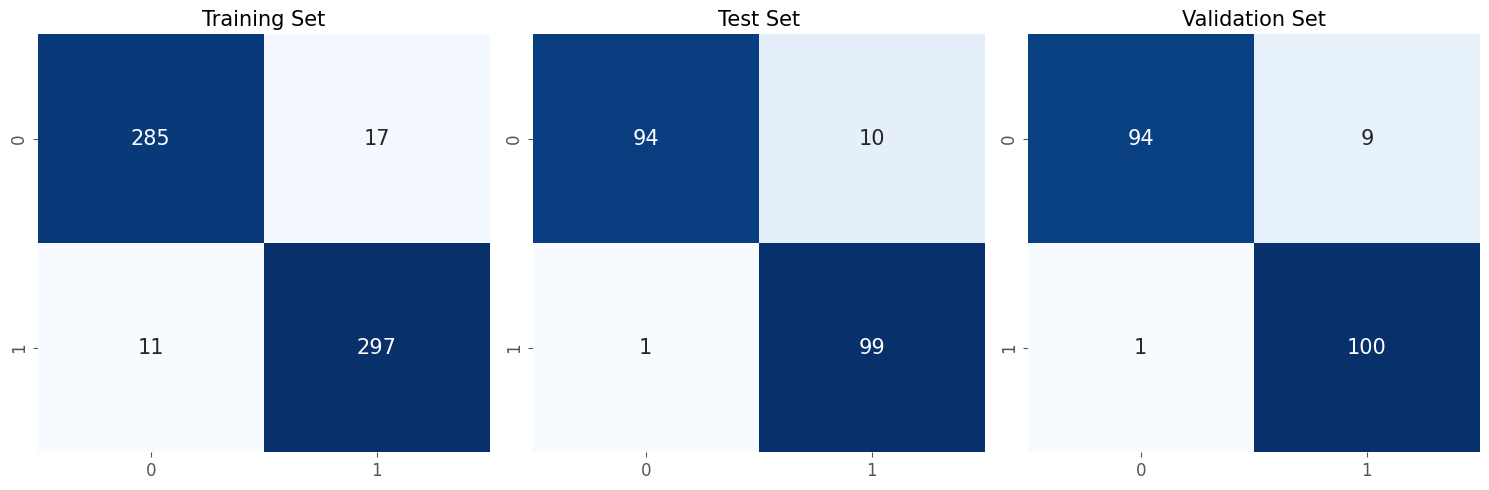

In [71]:
# Compute confusion matrix for training / test / validation sets
confusion_train = confusion_matrix(y_train, train_preds.round())
confusion_test = confusion_matrix(y_test, test_preds.round())
confusion_val = confusion_matrix(y_val, validation_preds.round())


# Set up subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Plot training set confusion matrix
sns.heatmap(confusion_train, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 15}, ax=axes[0])
axes[0].set_title('Training Set', fontsize=15)  # Adjust title font size

# Plot test set confusion matrix
sns.heatmap(confusion_test, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 15}, ax=axes[1])
axes[1].set_title('Test Set', fontsize=15)  # Adjust title font size

# Plot validation set confusion matrix
sns.heatmap(confusion_val, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 15}, ax=axes[2])
axes[2].set_title('Validation Set', fontsize=15)  # Adjust title font size

# Adjust tick label font size
for ax in axes:
    ax.tick_params(axis='both', labelsize=12)

# Display the plots
plt.tight_layout()
plt.show()


# Little interface to see how we perform outside our dataset

In [72]:
import gradio as gr

In [79]:
def preprocessing(post):
    post = lowering(post)
    post = remove_url(post)
    post  = remove_accents(post)
    post = remove_punctuation(post)
    post = remove_extra_spaces(post)
    return post

In [183]:
def create_columns(article):
    list_fordf = [article]
    data = pd.DataFrame(list_fordf,columns=['article'])
    # article_clean as a list, useful
    data['article_nopunct'] = data.article.apply(preprocessing)
    data['article_clean'] = data.article_nopunct.apply(delete_stopwords)
    data['article_list'] = data.article_nopunct.apply(str.split)
    data['length'] = data['article'].apply(article_length) 
    data['words'] = data['article'].apply(lambda x: len(str(x).split()))
    data['sentences'] = data['article'].map(lambda x: len(sent_tokenize(x)))
    data = data.apply(sum_bigram_counts, axis=1)

    vocabulary = Counter(reduce(lambda x,y : x+y, data.article_list.values))

    # get the vocabulary length and its log (for Herdan's C and MaaS)
    voc_len = len(vocabulary)
    log_voc_len = np.log(voc_len)

    # Herdan's C
    data['herdan'] = data.words.apply(lambda row: log_voc_len/np.log(row))

    # MaaS
    data['maas'] = data.words.apply(lambda row: (log_voc_len - np.log(row)) / np.log((voc_len**2)) )

    # Simpson's index 
    data['tf'] = data.article_list.apply(lambda row: Counter(row))
    data['tf'] = data.tf.apply(lambda row: row.values())
    simpson_help = zip(data.tf, list(data.words))
    data['simpson'] = list(simpson_help)
    data['simpson'] = data.simpson.apply(lambda row: [(val/row[1])**2 for val in row[0]]).apply(lambda row: 1-sum(row))

    # Grammar score 
    tool = language_tool_python.LanguageTool('en-US')
    data['grammar_score'] = data.article.apply(lambda row: len(tool.check(row))) #number of errors per row
    grammar_score_help = zip(data.grammar_score, data.words)
    data['grammar_score'] = list(grammar_score_help)
    data['grammar_score'] = data.grammar_score.apply(lambda row: (row[0]/row[1]) ) #compute grammar score

    # TTR on the whole text = on 1-grams (saved as TTR1)
    # for this section: type = len(tf), token = words
    data['TTR1'] = list(zip(list(data.tf.apply(len)), data.words))  #assign (type, token) as value for each row
    data['TTR1'] = data.TTR1.apply(lambda row: row[0]/row[1])       #compute TTR

    # TTR on 2-grams, prevalence of 2grams
    data['bigrams'] = data.article_clean.apply(str.split).apply(lambda row: nltk.ngrams(row, 2)) #create bigrams for each document
    data['TTR2'] = data.bigrams.apply(Counter                                     #count the occurency of each bigram
                                    ).apply(lambda row: (len(row), sum(row.values()) ) #returns (type, token) couple for each row
                                    ).apply(lambda row: row[0]/row[1] )                #computes TTR


    #TTR on 3-grams, prevalence of trigrams
    data['trigrams'] = data.article_clean.apply(str.split).apply(lambda row: nltk.ngrams(row, 3)) #create bigrams for each document
    data['TTR3'] = data.trigrams.apply(Counter                                    #count the occurencies of each trigram
                                    ).apply(lambda row: (len(row), sum(row.values()) ) #returns (type, token) couple for each row
                                    ).apply(lambda row: row[0]/row[1] )                #computes TTR


    # Average token length 
    data['avg_token_length'] = data.article_list.apply(lambda row: [len(word) for word in row]).apply(lambda row: sum(row)/len(row))

    # Perplexity 
    scorer = lmppl.LM('gpt2')
    data['perplexity'] = data.article.apply(scorer.get_perplexity)
    data.drop(['bigrams', 'trigrams', 'tf',"article", "article_clean", "article_nopunct", "article_list"], axis=1, inplace=True)
    data['maas'] = -999
    return data

In [194]:
def isAI(article):
    dataframe = create_columns(article)
    article_scaled = scaler.fit_transform(dataframe)
    article_scaled_bias = np.c_[np.ones(article_scaled.shape[0]), article_scaled]
    predicted = predictions(article_scaled_bias[0],theta_final)
    return predicted

In [198]:
prova = create_columns("data collection points estimators")

Using pad_token, but it is not set yet.
100%|██████████| 1/1 [00:00<00:00,  2.98it/s]


In [199]:
prova

,length,words,sentences,total_bigram_count,herdan,maas,simpson,grammar_score,TTR1,TTR2,TTR3,avg_token_length,perplexity
0,33,4,1,0,1.0,-999,0.75,0.25,1.0,1.0,1.0,7.5,2821.037436


In [202]:
article_scaled = scaler.transform(prova)
article_scaled

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:

article_scaled_bias = np.c_[np.ones(article_scaled.shape[0]), article_scaled]
predicted = predictions(article_scaled_bias[0], theta_final)

In [195]:
isAI("data point data")

Using pad_token, but it is not set yet.
100%|██████████| 1/1 [00:00<00:00,  4.19it/s]


0.471145468242668

In [196]:
app = gr.Interface(fn = isAI,
                   inputs = "text",
                   outputs = "number")

In [197]:
app.launch(share=True)

Running on local URL:  http://127.0.0.1:7862
Running on public URL: https://65bf415d84d0b2ee98.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [ ]:
demo = gr.ChatInterface()